In [1]:
import torch
import torch.nn as nn
from typing import List, Optional
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KDTree, BallTree
import pandas as pd
import pprint
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
import numpy as np
import pandas as pd
import torch
from models import BatchNormAutoencoder, DBOCSVM
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.svm import OneClassSVM
from sklearn.model_selection import KFold
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
)
import optuna
import matplotlib.pyplot as plt
import random
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)

/home/jbct/Projects/thesis/db-ocsvm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

with_storage_dbscan = False
with_storage_dbocsvm = False
dbscan_optuna_storage_path = "sqlite:///optuna_storage/dbscan_study.db"
ocsvm_optuna_storage_path = "sqlite:///optuna_storage/dbocsvm_study.db"

# Only need to change sample size, dataset paths, with_storage, ocsvm_trials

sample_size = 0.01
use_sample = True

use_full_train_set = True

best_model_path = "best_models/best_model_proposed.pth"

export_model = True
onnx_path = "saved_models/autoencoder.onnx"

use_existing_model = False
existing_model_path = (
    "saved_models/autoencoder_Model_1_hidden[96, 64]_latent55_best.pth"
)

existing_model_architecture = {
    "input_dim": 122,
    "hidden_dims": [96, 64],
    "latent_dim": 55,
    "activation_type": "LeakyReLU",
    "output_activation_type": "Sigmoid",
}

train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set_full.csv"
)
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)

In [3]:
# model architecture if not using existing model
new_model_architecture = {
    "hidden_dims": [116, 96, 64, 48],
    "latent_dim": 22,
    "activation_type": "LeakyReLU",
    "output_activation_type": "Sigmoid",
}

new_model_learning_parameters = {
    "lr": 0.001,
    "batch_size": 128,
    "epochs": 50,
    "improvement_threshold": 0.000000001,
    "good_model_threshold": 0.00015,
    "early_stopping_patience": 10,
}

In [4]:
dbscan_tuning_parameters = {
    "evaluation_metric": "silhouette",  # silhouette, calinski_harabasz, davies_bouldin
    "distance_metric": "manhattan",  # manhattan, euclidean
    "trials": 10,
}

dbocsvm_tree_algorithm = "kd_tree"  # "ball_tree" or "kd_tree"

ocsvm_trials = 15

import dataset

In [5]:
import pandas as pd

train_df = pd.read_csv(train_set_path)

if use_sample:
    train_df = train_df.sample(frac=sample_size, random_state=42).reset_index(drop=True)

print(train_df.shape)
train_df.head(1)

(673, 122)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,5.833486e-07,2.572642e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
from sklearn.model_selection import train_test_split

X_train_full = train_df.values

X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=42)
X_train = X_train.values
X_val = X_val.values

print(X_train.shape, X_val.shape, X_train_full.shape)

(538, 122) (135, 122) (673, 122)


In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

input_dim = X_train_full.shape[1]

training the autoencoder or use existing

In [8]:
from torch import nn, optim
from typing import List, Optional


class BatchNormAutoencoder(nn.Module):
    def __init__(
        self,
        input_dim: int = 128,
        hidden_dims: List[int] = [64, 32],
        latent_dim: int = 16,
        activation_type: str = "ReLU",
        output_activation_type: Optional[str] = None,
    ) -> None:
        super(BatchNormAutoencoder, self).__init__()

        # Select activation function
        activation: nn.Module
        if activation_type == "ReLU":
            activation = nn.ReLU()
        elif activation_type == "LeakyReLU":
            activation = nn.LeakyReLU()
        elif activation_type == "ELU":
            activation = nn.ELU()
        else:
            raise ValueError("Unknown activation type provided")

        # Build encoder
        encoder_layers: List[nn.Module] = []
        current_dim: int = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(nn.Linear(current_dim, h_dim))
            encoder_layers.append(nn.BatchNorm1d(h_dim))
            encoder_layers.append(activation)
            current_dim = h_dim

        # Latent layer
        encoder_layers.append(nn.Linear(current_dim, latent_dim))
        self.encoder: nn.Sequential = nn.Sequential(*encoder_layers)

        # Select output activation function
        output_activation: Optional[nn.Module] = None
        if output_activation_type == "ReLU":
            output_activation = nn.ReLU()
        elif output_activation_type == "LeakyReLU":
            output_activation = nn.LeakyReLU()
        elif output_activation_type == "ELU":
            output_activation = nn.ELU()
        elif output_activation_type == "Sigmoid":
            output_activation = nn.Sigmoid()
        elif output_activation_type == "Tanh":
            output_activation = nn.Tanh()
        elif output_activation_type is None:
            output_activation = None
        else:
            raise ValueError("Unknown activation type provided")

        # Build decoder
        decoder_layers: List[nn.Module] = []
        current_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(current_dim, h_dim))
            decoder_layers.append(nn.BatchNorm1d(h_dim))
            decoder_layers.append(activation)
            current_dim = h_dim

        # Add final output layer (no batch norm on output layer)
        decoder_layers.append(nn.Linear(current_dim, input_dim))

        # Add output activation if specified
        if output_activation is not None:
            decoder_layers.append(output_activation)

        self.decoder: nn.Sequential = nn.Sequential(*decoder_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded: torch.Tensor = self.encoder(x)
        decoded: torch.Tensor = self.decoder(encoded)
        return decoded

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

In [9]:
if use_existing_model:
    autoencoder = BatchNormAutoencoder(
        input_dim=existing_model_architecture["input_dim"],
        hidden_dims=existing_model_architecture["hidden_dims"],
        latent_dim=existing_model_architecture["latent_dim"],
        activation_type=existing_model_architecture["activation_type"],
        output_activation_type=existing_model_architecture["output_activation_type"],
    )
else:
    # Create model
    autoencoder = BatchNormAutoencoder(
        input_dim=input_dim,
        hidden_dims=new_model_architecture["hidden_dims"],
        latent_dim=new_model_architecture["latent_dim"],
        activation_type=new_model_architecture["activation_type"],
        output_activation_type=new_model_architecture["output_activation_type"],
    )

    # loss and optimizer
    optimizer = optim.Adam(
        autoencoder.parameters(), lr=new_model_learning_parameters["lr"]
    )
    criterion = nn.MSELoss()

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=new_model_learning_parameters["batch_size"],
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=new_model_learning_parameters["batch_size"],
    shuffle=False,
)

In [11]:
import matplotlib.pyplot as plt

def train_autoencoder(
    model: nn.Module,
    train_loader: DataLoader,
    optimizer: optim.Optimizer,
    criterion: nn.Module,
    val_loader: DataLoader = None,
    epochs: int = 10,
    best_model_path: str = "./best_autoencoder_tuning.pth",
    verbose: bool = False,
    early_stopping_patience: int = 5,
    improvement_threshold: float = 0.001,  # Minimum improvement to be considered significant
    good_model_threshold: float = 0.05,  # Threshold for considering a model "good"
    plot_results: bool = True,
):
    """
    Train an autoencoder model with early stopping and model saving capabilities.

    This function handles the complete training workflow for an autoencoder, including:
    - Forward/backward passes and optimization
    - Loss tracking for training and validation
    - Early stopping when improvement plateaus
    - Saving the best model based on validation or training loss
    - Optional progress reporting and loss curve plotting
    - Model quality assessment based on final reconstruction loss

    Parameters
    ----------
    model : nn.Module
        The autoencoder model to train
    train_loader : DataLoader
        PyTorch DataLoader for training data
    optimizer : optim.Optimizer
        PyTorch optimizer for model parameter updates
    criterion : nn.Module
        Loss function (typically MSELoss for autoencoders)
    val_loader : DataLoader, optional
        PyTorch DataLoader for validation data, by default None
    epochs : int, optional
        Maximum number of training epochs, by default 10
    best_model_path : str, optional
        Path to save the best model checkpoint, by default "./best_autoencoder_tuning.pth"
    verbose : bool, optional
        Whether to print training progress, by default False
    early_stopping_patience : int, optional
        Number of epochs with no improvement after which to stop training, by default 5
    improvement_threshold : float, optional
        Minimum improvement in loss to be considered significant, by default 0.001
    good_model_threshold : float, optional
        Maximum loss value for a model to be considered "good", by default 0.05
    plot_results : bool, optional
        Whether to plot loss curves after training, by default True

    Returns
    -------
    tuple
        (history, is_good_model) where:
        - history: dict with loss values over epochs
        - is_good_model: bool indicating if model meets quality threshold

    Notes
    -----
    - When validation data is provided, early stopping is based on validation loss,
      otherwise training loss is used
    - The best model is loaded at the end of training
    - If best_val_loss < good_model_threshold, the model is considered good
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model.to(device)

    if verbose:
        print("")
        print(f"Using device: {device}")
        print("Training autoencoder...")

    history = {"loss": [], "val_loss": []}
    model.train()

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):

        total_loss = 0.0
        for batch in train_loader:
            batch_x = batch[0].to(device)

            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_x)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        history["loss"].append(avg_loss)

        if val_loader is not None:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for val_batch in val_loader:
                    val_inputs = val_batch[0].to(device)
                    val_outputs = model(val_inputs)
                    batch_val_loss = criterion(val_outputs, val_inputs).item()
                    val_loss += batch_val_loss

            avg_val_loss = val_loss / len(val_loader)
            history["val_loss"].append(avg_val_loss)

            if verbose:
                print(
                    f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.10f}, Val Loss: {avg_val_loss:.10f}"
                )
            # Save model if validation loss improved
            if avg_val_loss < best_val_loss:
                improvement = best_val_loss - avg_val_loss

                # Check if improvement is significant
                if improvement > improvement_threshold:
                    patience_counter = 0  # Reset patience counter
                else:
                    patience_counter += 1

                # Save the model
                best_val_loss = avg_val_loss
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "val_loss": best_val_loss,
                    },
                    best_model_path,
                )

                if verbose:
                    print(f"✅ Model saved with val_loss: {best_val_loss:.10f}")

                model.train()
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                if verbose:
                    print(
                        f"Early stopping triggered after {epoch+1} epochs due to lack of improvement."
                    )
                break
        else:
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.10f}")

            # If no validation set, save based on training loss
            if avg_loss < best_val_loss:
                improvement = best_val_loss - avg_loss

                # Check if improvement is significant
                if improvement > improvement_threshold:
                    patience_counter = 0
                else:
                    patience_counter += 1

                best_val_loss = avg_loss
                torch.save(
                    {
                        "epoch": epoch,
                        "model_state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "train_loss": best_val_loss,
                    },
                    best_model_path,
                )

                if verbose:
                    print(f"✅ Model saved with train_loss: {best_val_loss:.10f}")
            else:
                patience_counter += 1

            # Check early stopping conditions
            if patience_counter >= early_stopping_patience:
                if verbose:
                    print(
                        f"Early stopping triggered after {epoch+1} epochs due to lack of improvement."
                    )
                break

    if plot_results:
        plt.figure(figsize=(15, 10))
        plt.plot(history["loss"], label="Training Loss")
        if "val_loss" in history and history["val_loss"]:
            plt.plot(history["val_loss"], label="Validation Loss")
        plt.title(f"Loss History (Epoch {epoch+1})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.close()

        # Load best model
        checkpoint = torch.load(best_model_path)
        model.load_state_dict(checkpoint["model_state_dict"])
        best_loss = checkpoint.get("val_loss", checkpoint.get("train_loss"))

    if best_loss < good_model_threshold:
        print(f"Model is good with loss {best_loss}")
        is_good_model = True
    else:
        print(f"Model is bad with loss {best_loss}")
        is_good_model = False

    return history, is_good_model


Using device: cpu
Training autoencoder...
Epoch 1/50, Train Loss: 0.2360623449, Val Loss: 0.2365447879
✅ Model saved with val_loss: 0.2365447879
Epoch 2/50, Train Loss: 0.1874300480, Val Loss: 0.2155820504
✅ Model saved with val_loss: 0.2155820504
Epoch 3/50, Train Loss: 0.1409711510, Val Loss: 0.1799286380
✅ Model saved with val_loss: 0.1799286380
Epoch 4/50, Train Loss: 0.1032067284, Val Loss: 0.1365063339
✅ Model saved with val_loss: 0.1365063339
Epoch 5/50, Train Loss: 0.0738685206, Val Loss: 0.1001007706
✅ Model saved with val_loss: 0.1001007706
Epoch 6/50, Train Loss: 0.0534784734, Val Loss: 0.0762121640
✅ Model saved with val_loss: 0.0762121640
Epoch 7/50, Train Loss: 0.0398948975, Val Loss: 0.0586739685
✅ Model saved with val_loss: 0.0586739685
Epoch 8/50, Train Loss: 0.0312613927, Val Loss: 0.0445429590
✅ Model saved with val_loss: 0.0445429590
Epoch 9/50, Train Loss: 0.0248324521, Val Loss: 0.0323171280
✅ Model saved with val_loss: 0.0323171280
Epoch 10/50, Train Loss: 0.021

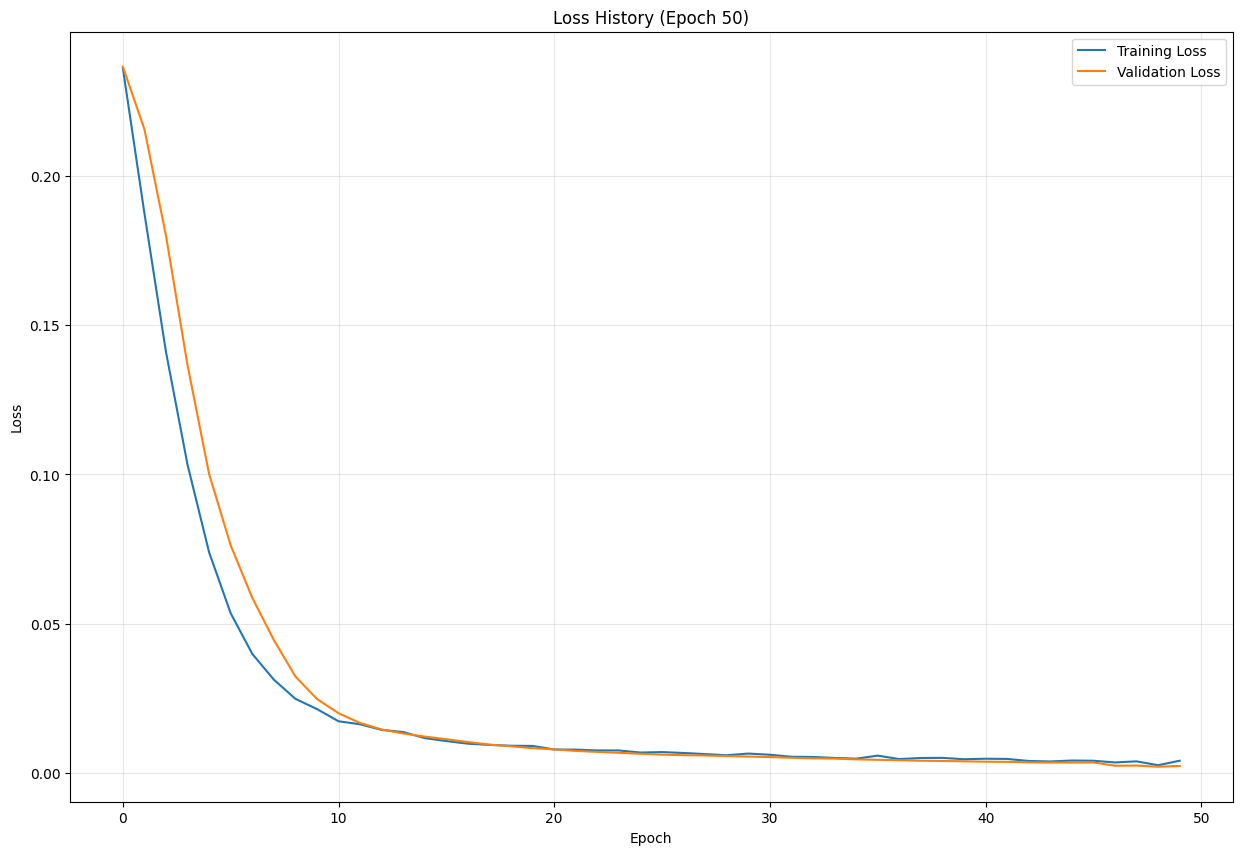

Model is bad with loss 0.0020988932228647172


In [12]:
if not use_existing_model:
    history, is_good_model = train_autoencoder(
        model=autoencoder,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=new_model_learning_parameters["epochs"],
        best_model_path=best_model_path,
        verbose=True,
        early_stopping_patience=new_model_learning_parameters[
            "early_stopping_patience"
        ],
        improvement_threshold=new_model_learning_parameters["improvement_threshold"],
        good_model_threshold=new_model_learning_parameters["good_model_threshold"],
        plot_results=True,
    )

In [13]:
print("Pytorch model saved at:", best_model_path)

Pytorch model saved at: best_models/best_model_proposed.pth


In [14]:
# Load best model
if use_existing_model:
    checkpoint = torch.load(existing_model_path)
    autoencoder.load_state_dict(checkpoint["model_state_dict"])
else:
    checkpoint = torch.load(best_model_path)
    autoencoder.load_state_dict(checkpoint["model_state_dict"])

autoencoder.eval()

BatchNormAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=122, out_features=116, bias=True)
    (1): BatchNorm1d(116, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=116, out_features=96, bias=True)
    (4): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=96, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=64, out_features=48, bias=True)
    (10): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=48, out_features=22, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=22, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momen

saving the model

In [15]:
import torch.onnx

if export_model and not use_existing_model:
    # Prepare a sample input tensor with the correct shape
    dummy_input = torch.randn(1, input_dim, device=device)

    torch.onnx.export(
        autoencoder,  # model being run
        dummy_input,  # model input
        onnx_path,  # where to save the model
        export_params=True,  # store trained parameters inside model file
        opset_version=17,  # ONNX version
        do_constant_folding=True,  # optimize constant folding
        input_names=["input"],  # model's input names
        output_names=["output"],  # model's output names
        dynamic_axes={
            "input": {0: "batch_size"},  # variable length axes
            "output": {0: "batch_size"},
        },
    )

    print(f"Model exported to ONNX format: {onnx_path}")

Model exported to ONNX format: saved_models/autoencoder.onnx


dbscan tuning

In [16]:
import numpy as np

# extract encoded features
X_train_full_tensor = torch.FloatTensor(X_train_full)
X_train_full_dataset = TensorDataset(X_train_full_tensor)
X_train_full_loader = DataLoader(X_train_full_dataset, batch_size=256)

# Extract in batches to prevent memory issues
if use_full_train_set:
    X_encoded = []
    with torch.no_grad():
        for data in X_train_full_loader:
            data_x = data[0].to(device)
            encoded = autoencoder.encode(data_x)
            X_encoded.append(encoded.cpu().numpy())
    X_encoded = np.vstack(X_encoded)
else:
    X_encoded = []
    with torch.no_grad():
        for data in train_loader:
            data_x = data[0].to(device)
            encoded = autoencoder.encode(data_x)
            X_encoded.append(encoded.cpu().numpy())
    X_encoded = np.vstack(X_encoded)

In [17]:
def find_eps_range_with_elbow_method(X, k=20, multiplier=(0.5, 2.0), plot=True):
    """
    Find a suitable eps range for DBSCAN using the elbow method.

    Parameters:
    -----------
    X : array-like
        The encoded data points
    k : int, default=20
        Number of neighbors to consider (corresponds to min_samples)
    multiplier : tuple, default=(0.5, 2.0)
        Factors to multiply the elbow point by to create a range
    plot : bool, default=True
        Whether to show the k-distance plot

    Returns:
    --------
    tuple
        (min_eps, max_eps) suitable range for eps parameter
    """

    # Calculate distances to k nearest neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=k, metric="manhattan").fit(X)
    distances, _ = nbrs.kneighbors(X)

    # Sort the distances to the kth neighbor in ascending order
    k_distances = np.sort(distances[:, -1])

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(k_distances)
        plt.xlabel("Points (sorted)")
        plt.ylabel(f"Distance to {k}th nearest neighbor")
        plt.title("K-distance Plot for DBSCAN eps Selection")
        plt.grid(True, alpha=0.3)

        # Add horizontal lines at suggested eps range
        # This will be calculated below

        plt.show()

    # Find the elbow point (simple method - you might want a more sophisticated approach)
    # Look for maximum curvature in the sorted distance plot
    n_points = len(k_distances)
    all_coords = np.vstack((range(n_points), k_distances)).T

    # Compute point-to-line distances for all points
    line_vec = all_coords[-1] - all_coords[0]
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coords - all_coords[0]
    scalar_prod = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_to_line = vec_from_first - np.outer(scalar_prod, line_vec_norm)
    dist_to_line = np.sqrt(np.sum(vec_to_line**2, axis=1))

    # Elbow point is the point with max distance to the line
    elbow_idx = np.argmax(dist_to_line)
    elbow_eps = k_distances[elbow_idx]

    # Create a range around the elbow point
    min_eps = elbow_eps * multiplier[0]
    max_eps = elbow_eps * multiplier[1]

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(k_distances)
        plt.axhline(
            y=min_eps,
            color="r",
            linestyle="--",
            alpha=0.7,
            label=f"Min eps: {min_eps:.2f}",
        )
        plt.axhline(
            y=elbow_eps,
            color="g",
            linestyle="-",
            alpha=0.7,
            label=f"Elbow eps: {elbow_eps:.2f}",
        )
        plt.axhline(
            y=max_eps,
            color="r",
            linestyle="--",
            alpha=0.7,
            label=f"Max eps: {max_eps:.2f}",
        )
        plt.axvline(x=elbow_idx, color="g", linestyle=":", alpha=0.5)
        plt.xlabel("Points (sorted)")
        plt.ylabel(f"Distance to {k}th nearest neighbor")
        plt.title("K-distance Plot with Suggested eps Range")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    return min_eps, max_eps

In [18]:
input_dim_encoded = X_encoded.shape[1]

k_for_elbow = int((20 + input_dim_encoded * 2) / 2)
min_eps, max_eps = find_eps_range_with_elbow_method(
    X_encoded,
    k=k_for_elbow,
    plot=False,
)
min_eps, max_eps

(np.float64(3.381192207336426), np.float64(13.524768829345703))

In [19]:
def objective_dbscan(
    trial: optuna.Trial,
    X_encoded: np.ndarray,
    evaluation_metric: str = "silhouette",
    eps_range: tuple[float, float] = (0.1, 15.0),
    min_samples_range: tuple[int, int] = (20, 50),
    distance_metric: str = "euclidean",  # "manhattan", "cosine"
    n_jobs: int = -1,
) -> float:
    """
    Inner objective function for optimizing DBSCAN clustering hyperparameters.

    This function is used by Optuna for hyperparameter optimization of a DBSCAN model.
    It evaluates different clustering configurations using the specified evaluation metric.

    Parameters
    ----------
    trial : optuna.Trial
        Optuna trial object used for hyperparameter suggestion
    X_encoded : np.ndarray
        Array of encoded data points to cluster
    evaluation_metric : str, default="silhouette"
        Metric to evaluate cluster quality: "silhouette", "davies_bouldin", or "calinski_harabasz"
    eps_range : tuple[float, float], default=(0.1, 15.0)
        Range (min, max) for the eps parameter of DBSCAN
    min_samples_range : tuple[int, int], default=(20, 50)
        Range (min, max) for the min_samples parameter of DBSCAN
    metric : str, default="euclidean"
        Distance metric for DBSCAN
    score_threshold : float, default=0.60
        Minimum score threshold to consider a clustering configuration valid
    n_jobs : int, default=-1
        Number of parallel jobs to run for DBSCAN

    Returns
    -------
    float
        Clustering quality score (higher is better) unless evaluation_metric is "davies_bouldin"
        Returns -inf for invalid clustering configurations
    """

    def get_score(X, labels, metric_name, mask=None):
        if mask is not None:
            X = X[mask]
            labels = labels[mask]

        if metric_name == "silhouette":
            return silhouette_score(X, labels)
        elif metric_name == "davies_bouldin":
            return -davies_bouldin_score(
                X, labels
            )  # Negative because we want to maximize
        elif metric_name == "calinski_harabasz":
            return calinski_harabasz_score(X, labels)
        else:
            raise ValueError(f"Unknown metric: {metric_name}")

    eps = trial.suggest_float("eps", eps_range[0], eps_range[1])
    min_samples = trial.suggest_int(
        "min_samples", min_samples_range[0], min_samples_range[1]
    )

    dbscan = DBSCAN(
        eps=eps, min_samples=min_samples, metric=distance_metric, n_jobs=n_jobs
    )

    cluster_labels = dbscan.fit_predict(X_encoded)

    # Calculate the number of clusters (excluding noise points)
    unique_clusters = set(cluster_labels)
    n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)

    # Set custom attribute for number of clusters
    trial.set_user_attr("n_clusters", n_clusters)

    # Set custom attribute for cluster data points
    cluster_data_points = {}
    for cluster_id in unique_clusters:
        # Store indices of points in each cluster
        cluster_indices = np.where(cluster_labels == cluster_id)[0].tolist()
        cluster_data_points[int(cluster_id)] = len(cluster_indices)
    trial.set_user_attr("cluster_data_points", cluster_data_points)

    if n_clusters < 2:
        print("not enough clusters")
        return -float("inf")  # Penalize solutions with too few clusters

    # For silhouette score, we need to exclude noise points (-1)
    if evaluation_metric == "silhouette":
        mask = cluster_labels != -1
        if sum(mask) < 2:
            print("not enough points in clusters")
            return -float("inf")
        score = get_score(X_encoded, cluster_labels, evaluation_metric, mask)
    else:
        score = get_score(X_encoded, cluster_labels, evaluation_metric)

    return score

In [20]:
import optuna

dbscan_objective_lambda = lambda trial: objective_dbscan(
    trial,
    X_encoded=X_encoded,
    evaluation_metric=dbscan_tuning_parameters["evaluation_metric"],
    eps_range=(min_eps, max_eps),
    min_samples_range=(1, input_dim_encoded * 2),
    distance_metric=dbscan_tuning_parameters["distance_metric"],
    n_jobs=-1,
)

if with_storage_dbscan:
    dbscan_study = optuna.create_study(
        direction="maximize",
        storage=dbscan_optuna_storage_path,
        study_name="dbscan_study",
        load_if_exists=True,
    )
    dbscan_study.optimize(
        dbscan_objective_lambda,
        n_trials=dbscan_tuning_parameters["trials"],
    )
else:
    dbscan_study = optuna.create_study(direction="maximize")
    dbscan_study.optimize(
        dbscan_objective_lambda,
        n_trials=dbscan_tuning_parameters["trials"],
    )

[I 2025-03-07 02:48:21,153] A new study created in memory with name: no-name-4e2edb69-c4fe-48df-8e82-c04c122d8d93
[I 2025-03-07 02:48:21,235] Trial 0 finished with value: 0.4842154085636139 and parameters: {'eps': 6.871603027419332, 'min_samples': 27}. Best is trial 0 with value: 0.4842154085636139.
[I 2025-03-07 02:48:21,319] Trial 1 finished with value: 0.5935849547386169 and parameters: {'eps': 4.58433142702699, 'min_samples': 12}. Best is trial 1 with value: 0.5935849547386169.
[I 2025-03-07 02:48:21,392] Trial 2 finished with value: 0.5916091799736023 and parameters: {'eps': 5.126327406968786, 'min_samples': 7}. Best is trial 1 with value: 0.5935849547386169.
[I 2025-03-07 02:48:21,468] Trial 3 finished with value: 0.35603421926498413 and parameters: {'eps': 6.991612085238597, 'min_samples': 6}. Best is trial 1 with value: 0.5935849547386169.
[I 2025-03-07 02:48:21,533] Trial 4 finished with value: 0.5856406688690186 and parameters: {'eps': 5.429667012281406, 'min_samples': 8}. Be

not enough clusters
not enough clusters


In [21]:
import pprint

# get dbscan best parameters
eps = dbscan_study.best_params["eps"]
min_samples = dbscan_study.best_params["min_samples"]

# get dbscan best trial
best_trial_dbscan = dbscan_study.best_trial
best_trial_dbscan_user_attrs = best_trial_dbscan.user_attrs

n_clusters = best_trial_dbscan_user_attrs["n_clusters"]
cluster_data_points = best_trial_dbscan_user_attrs["cluster_data_points"]

print(f"eps = {eps}")
print(f"min_samples = {min_samples}")
print(f"n_clusters = {n_clusters}")
print("cluster_data_points")
pprint.pprint(cluster_data_points)

eps = 4.948898414372888
min_samples = 18
n_clusters = 6
cluster_data_points
{-1: 89, 0: 82, 1: 325, 2: 85, 3: 33, 4: 36, 5: 23}


fit the DBSCAN

In [22]:
class DBOCSVM_V2:
    def __init__(
        self,
        kernel="rbf",
        gamma="scale",
        nu=0.5,
        eps=0.5,
        min_samples=10,
        tree_metric="euclidean",
        dbscan_metric="euclidean",
        algorithm="kd_tree",  # or 'ball_tree'
        n_jobs=-1,  # Add n_jobs parameter
    ):
        self.kernel = kernel
        self.gamma = gamma
        self.nu = nu
        self.algorithm = algorithm
        self.tree_metric = tree_metric
        self.dbscan_metric = dbscan_metric
        self.dbscan = DBSCAN(
            eps=eps, min_samples=min_samples, n_jobs=n_jobs, metric=dbscan_metric
        )  # Make it so that it can accept a metric parameter
        self.svms = {}  # One SVM per cluster
        self.dbscan_centroids = {}  # To store cluster centroids
        self.cluster_points = {}  # Store points in each cluster
        self.tree = None
        # These attributes are mainly used for inspection purposes
        self.cluster_sizes = {}  # Number of points in each cluster
        self.n_jobs = n_jobs  # Store n_jobs
        self.cluster_labels = None
        self.unique_clusters = None

    def fit_cluster(
        self,
        X,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        """

        X = X.values if isinstance(X, pd.DataFrame) else X

        """
        NOTE: Current DBSCAN only uses euclidean distance, so the metric parameter is not used
        TODO: Add metric parameter to DBSCAN to handle different distance metrics
        'euclidean': Standard Euclidean distance. This is the default metric.
        'manhattan': Manhattan or L1 distance (sum of absolute differences).
        'chebyshev': Chebyshev or maximum distance.
        'minkowski': Minkowski distance, a generalization of Euclidean and Manhattan distance. The power parameter p of the Minkowski metric can be controlled by the p parameter of DBSCAN.
        'wminkowski': Weighted Minkowski distance.
        'seuclidean': Standardized Euclidean distance.
        'mahalanobis': Mahalanobis distance.
        """

        if verbose:
            print("Fitting DBSCAN...")
        # NOTE: we use the dbscan that was initialized in the constructor
        self.cluster_labels = self.dbscan.fit_predict(X)

        if verbose:
            print("DBSCAN Fitted...")

        self.unique_clusters = np.unique(self.cluster_labels)

        if verbose:
            print(f"Unique Clusters: {self.unique_clusters}")

        for cluster in self.unique_clusters:
            n_points = np.sum(self.cluster_labels == cluster)
            self.cluster_sizes[int(cluster)] = int(n_points)

        if verbose:
            print(f"Cluster Sizes: {self.cluster_sizes}")

    def fit_ocsvm(
        self,
        X,
        parameter_list=None,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        parameter_list: dictionary of dictionaries
            Each key in the dictionary is the cluster number and
            the value is a dictionary containing the parameters for OCSVM
            each dictionary looks like this:
            {
                0 : {
                kernel: rbf, linear, poly, or sigmoid,
                gamma: 'scale', 'auto' or a float,
                nu: a float between 0 and 1 e.g 0.2,
                }
            }
        """
        X = X.values if isinstance(X, pd.DataFrame) else X

        if parameter_list is None:
            raise ValueError("parameter_list cannot be None")

        if len(parameter_list) < len(self.unique_clusters) - 1:
            raise ValueError(
                "Number of parameters should be equal or greater than the number of clusters"
            )

        def filter_dict(original_dict, keys_to_keep):
            return {k: original_dict[k] for k in keys_to_keep if k in original_dict}

        if len(parameter_list) >= len(self.unique_clusters) - 1:
            cluster_count = list(self.cluster_sizes.keys())
            if -1 in cluster_count:
                cluster_count.remove(-1)
            cluster_count

            parameter_list = filter_dict(parameter_list, cluster_count)

        for cluster in self.unique_clusters:

            if cluster == -1:  # Skip noise cluster for SVM training
                continue

            if verbose:
                print(
                    f"Training for cluster {cluster} with {self.cluster_sizes[cluster]} points"
                )

            # Boolean masking to get points in the current cluster
            points = X[self.cluster_labels == cluster]
            self.cluster_points[cluster] = points

            if len(points) > 0:
                # use parameters defined in constructor if not provided
                if parameter_list is None:
                    ocsvm = OneClassSVM(
                        kernel=self.kernel,
                        nu=self.nu,
                        gamma=self.gamma,
                    )
                else:
                    ocsvm = OneClassSVM(
                        kernel=parameter_list[cluster]["kernel"],
                        nu=parameter_list[cluster]["nu"],
                        gamma=parameter_list[cluster]["gamma"],
                    )
                    if verbose:
                        print(
                            f"OCSVM for cluster {cluster} uses nu: {parameter_list[cluster]['nu']}, gamma: {parameter_list[cluster]['gamma']}, kernel: {parameter_list[cluster]['kernel']}"
                        )

                ocsvm.fit(points)

                self.svms[cluster] = ocsvm

                """
                TODO: Explore other alternatives for centroid calculation
                "->" means the following line might be a downside of the current approach.
                
                - Median: More robust to outliers than the mean (`np.median(points, axis=0)`).
                    -> Less representative if data is asymmetric  
                - Trimmed Mean: Removes extreme values before computing the mean (`scipy.stats.trim_mean`).
                    ->   Requires choosing the trimming percentage
                - Weighted Mean: Assigns importance to points based on reliability.  
                    ->  Requires defining weights
                - Geometric Median: Minimizes sum of distances to all points. More robust to outliers than the mean.
                    -> computationally expensive (`scipy.spatial`)
                - Distance Metrics: Use median for Manhattan distance and mean for Euclidean distance.
                    -> Requires choosing the distance metric
                    
                """
                self.dbscan_centroids[cluster] = np.mean(points, axis=0)

        # Build tree with cluster centroids
        centroids = [self.dbscan_centroids[c] for c in self.dbscan_centroids if c != -1]
        self.valid_clusters = list(self.dbscan_centroids.keys())
        if len(centroids) > 0:
            centroids = np.array(centroids)
            if self.algorithm == "kd_tree":
                self.tree = KDTree(centroids, metric=self.tree_metric)
            elif self.algorithm == "ball_tree":
                self.tree = BallTree(centroids, metric=self.tree_metric)

    def fit(
        self,
        X,
        dbscan_evaluation_metric="silhouette",  # only used for reruns
        dbscan_rerun=False,  # only used for reruns
        dbscan_rerun_trials=10,  # only used for reruns
        parameter_list=None,
        verbose=False,
    ):
        """
        Parameters:
        -----------
        X : array-like
            Training data
        dbscan_evaluation_metric : str
            Metric to optimize ('silhouette', 'davies_bouldin', or 'calinski_harabasz')
        dbscan_rerun : bool
            Whether to rerun DBSCAN after fitting the model with the best parameters
        dbscan_rerun_trials : int
            Number of reruns for DBSCAN after fitting the model with the best parameters
        parameter_list: dictionary of dictionaries
            Each key in the dictionary is the cluster number and
            the value is a dictionary containing the parameters for OCSVM
            each dictionary looks like this:
            {
                0 : {
                kernel: rbf, linear, poly, or sigmoid,
                gamma: 'scale', 'auto' or a float,
                nu: a float between 0 and 1 e.g 0.2,
                }
            }
        """

        X = X.values if isinstance(X, pd.DataFrame) else X

        """
        NOTE: Current DBSCAN only uses euclidean distance, so the metric parameter is not used
        TODO: Add metric parameter to DBSCAN to handle different distance metrics
        'euclidean': Standard Euclidean distance. This is the default metric.
        'manhattan': Manhattan or L1 distance (sum of absolute differences).
        'chebyshev': Chebyshev or maximum distance.
        'minkowski': Minkowski distance, a generalization of Euclidean and Manhattan distance. The power parameter p of the Minkowski metric can be controlled by the p parameter of DBSCAN.
        'wminkowski': Weighted Minkowski distance.
        'seuclidean': Standardized Euclidean distance.
        'mahalanobis': Mahalanobis distance.
        """
        if verbose:
            print("Fitting DBSCAN...")
        # NOTE: we use the dbscan that was initialized in the constructor
        cluster_labels = self.dbscan.fit_predict(X)
        if verbose:
            print("DBSCAN Fitted...")

        if dbscan_rerun:
            if verbose:
                print("Rerunning DBSCAN...")

            if dbscan_evaluation_metric == "silhouette":
                current_score = silhouette_score(X, cluster_labels)
            elif dbscan_evaluation_metric == "davies_bouldin":
                current_score = davies_bouldin_score(X, cluster_labels)
            else:  # calinski_harabasz
                current_score = calinski_harabasz_score(X, cluster_labels)

            for i in range(dbscan_rerun_trials):
                if verbose:
                    print(f"DBSCAN Rerun {i+1}...")

                new_cluster_labels = self.dbscan.fit_predict(X)

                if dbscan_evaluation_metric == "silhouette":
                    new_score = silhouette_score(X, new_cluster_labels)
                    if new_score > current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score
                elif dbscan_evaluation_metric == "davies_bouldin":
                    new_score = davies_bouldin_score(X, new_cluster_labels)
                    if new_score < current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score
                else:  # calinski_harabasz
                    new_score = calinski_harabasz_score(X, new_cluster_labels)
                    if new_score > current_score:
                        cluster_labels = new_cluster_labels
                        current_score = new_score

        unique_clusters = np.unique(cluster_labels)

        if verbose:
            print(f"Unique Clusters: {unique_clusters}")

        for cluster in unique_clusters:
            # Store the number of points in the cluster
            # mainly for inspection purposes
            n_points = np.sum(cluster_labels == cluster)
            self.cluster_sizes[int(cluster)] = int(n_points)

        if verbose:
            print(f"Cluster Sizes: {self.cluster_sizes}")

        if parameter_list is not None and (len(parameter_list)) < (
            len(unique_clusters) - 1
        ):
            raise ValueError(
                "Number of parameters should be equal or greater than the number of clusters"
            )

        def filter_dict(original_dict, keys_to_keep):
            return {k: original_dict[k] for k in keys_to_keep if k in original_dict}

        if parameter_list is not None and (len(parameter_list)) >= (
            len(unique_clusters) - 1
        ):
            cluster_count = list(self.cluster_sizes.keys())
            cluster_count.remove(-1)
            cluster_count

            parameter_list = filter_dict(parameter_list, cluster_count)

        self.parameter_list = parameter_list

        for cluster in unique_clusters:

            # Store the number of points in the cluster
            # n_points = np.sum(cluster_labels == cluster)
            # self.cluster_sizes[int(cluster)] = int(n_points)

            if cluster == -1:  # Skip noise cluster for SVM training
                continue

            if verbose:
                print(
                    f"Training for cluster {cluster} with {self.cluster_sizes[cluster]} points"
                )

            # Boolean masking to get points in the current cluster
            points = X[cluster_labels == cluster]
            self.cluster_points[cluster] = points

            if len(points) > 0:
                # use parameters defined in constructor if not provided
                if parameter_list is None:
                    ocsvm = OneClassSVM(
                        kernel=self.kernel,
                        nu=self.nu,
                        gamma=self.gamma,
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        max_iter=self.max_iter,
                    )
                else:
                    ocsvm = OneClassSVM(
                        kernel=parameter_list[cluster]["kernel"],
                        nu=parameter_list[cluster]["nu"],
                        gamma=parameter_list[cluster]["gamma"],
                        degree=self.degree,
                        coef0=self.coef0,
                        tol=self.tol,
                        shrinking=self.shrinking,
                        cache_size=self.cache_size,
                        max_iter=self.max_iter,
                    )
                    if verbose:
                        print(
                            f"OCSVM for cluster {cluster} uses nu: {parameter_list[cluster]['nu']}, gamma: {parameter_list[cluster]['gamma']}, kernel: {parameter_list[cluster]['kernel']}"
                        )
                ocsvm.fit(points)

                self.svms[cluster] = ocsvm

                """
                TODO: Explore other alternatives for centroid calculation
                "->" means the following line might be a downside of the current approach.
                
                - Median: More robust to outliers than the mean (`np.median(points, axis=0)`).
                    -> Less representative if data is asymmetric  
                - Trimmed Mean: Removes extreme values before computing the mean (`scipy.stats.trim_mean`).
                    ->   Requires choosing the trimming percentage
                - Weighted Mean: Assigns importance to points based on reliability.  
                    ->  Requires defining weights
                - Geometric Median: Minimizes sum of distances to all points. More robust to outliers than the mean.
                    -> computationally expensive (`scipy.spatial`)
                - Distance Metrics: Use median for Manhattan distance and mean for Euclidean distance.
                    -> Requires choosing the distance metric
                    
                """
                self.dbscan_centroids[cluster] = np.mean(points, axis=0)

        # Build tree with cluster centroids
        centroids = [self.dbscan_centroids[c] for c in self.dbscan_centroids if c != -1]
        self.valid_clusters = list(self.dbscan_centroids.keys())
        if len(centroids) > 0:
            centroids = np.array(centroids)
            if self.algorithm == "kd_tree":
                self.tree = KDTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )
            elif self.algorithm == "ball_tree":
                self.tree = BallTree(
                    centroids, leaf_size=self.leaf_size, metric=self.tree_metric
                )

    def predict(self, X):
        predictions = np.ones(len(X))
        X = X.values if isinstance(X, pd.DataFrame) else X

        if self.tree is None:
            return -1 * np.ones(len(X))

        # Find nearest centroid
        dist, ind = self.tree.query(X, k=1)
        nearest_clusters = [self.valid_clusters[i] for i in ind.flatten()]

        for i, cluster in enumerate(nearest_clusters):
            if cluster in self.svms:
                predictions[i] = self.svms[cluster].predict([X[i]])[0]
            else:
                predictions[i] = -1  # Anomaly if no SVM for cluster

        return predictions

In [23]:
# Create DB-OC-SVM model with default ocsvm parameters
dbocsvm = DBOCSVM_V2(
    kernel="rbf",
    gamma="auto",
    nu=0.2,
    eps=eps,
    min_samples=min_samples,
    dbscan_metric=dbscan_tuning_parameters["distance_metric"],
    algorithm=dbocsvm_tree_algorithm,  # ball_tree, kd_tree,
)

In [24]:
dbocsvm.fit_cluster(X_encoded, verbose=True)

Fitting DBSCAN...
DBSCAN Fitted...
Unique Clusters: [-1  0  1  2  3  4  5]
Cluster Sizes: {-1: 89, 0: 82, 1: 325, 2: 85, 3: 33, 4: 36, 5: 23}


importing test set

In [25]:
test_df = pd.read_csv(test_set_path)
print(test_df.shape)
test_df.head(1)

(22543, 125)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,neptune,DoS


In [26]:
# Splitting into X and y
X_test = test_df.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_test = test_df["attack_binary"].values
y_test_class = test_df["attack_class"]

print(X_test.shape, y_test.shape)

(22543, 122) (22543,)


extract features from test data

In [27]:
X_test_tensor = torch.FloatTensor(X_test).to(device)

test_dataset = TensorDataset(X_test_tensor, torch.zeros(len(X_test_tensor)))
test_loader = DataLoader(test_dataset, batch_size=128)

X_test_encoded = []
with torch.no_grad():
    for data, _ in test_loader:
        encoded = autoencoder.encode(data)
        X_test_encoded.append(encoded.cpu().numpy())

X_test_encoded = np.vstack(X_test_encoded)
print(X_test_encoded.shape)

(22543, 22)


tuning the ocsvms

In [28]:
def objective_dbocsvm_fit_ocsvm(
    trial: optuna.Trial,
    model: DBOCSVM_V2,
    X_encoded_train: np.ndarray,
    X_encoded_test: np.ndarray,
    y_test: np.ndarray,
    cluster_count: int = 20,
) -> float:

    parameter_list = {}
    for cluster in range(0, cluster_count):
        hyperparameter = {
            "kernel": "rbf",
            "gamma": trial.suggest_float(f"gamma_{cluster}", 1e-4, 1.0),
            "nu": trial.suggest_float(f"nu_{cluster}", 0.01, 0.5),
        }
        parameter_list[cluster] = hyperparameter

    model.fit_ocsvm(X_encoded_train, parameter_list=parameter_list)

    y_pred = model.predict(X_encoded_test)

    acc = accuracy_score(y_test, y_pred)

    return acc


def inner_objective_dbocsvm(
    trial: optuna.Trial,
    X_encoded: np.ndarray,
    y: np.ndarray,
    cluster_count: int = 20,
    kfold_splits: int = 7,
    eps: float = 1.5,
    min_samples: int = 50,
    tree_algorithm: str = "kd_tree",  # "ball_tree"
) -> float:

    parameter_list = {}
    for cluster in range(0, cluster_count):
        hyperparameter = {
            "kernel": "rbf",
            "gamma": trial.suggest_float(f"gamma_{cluster}", 1e-4, 1.0, log=True),
            "nu": trial.suggest_float(f"nu_{cluster}", 0.01, 0.5),
        }
        parameter_list[cluster] = hyperparameter

    kf = KFold(n_splits=kfold_splits, shuffle=True, random_state=42)

    scores = []

    for train_idx, val_idx in kf.split(X_encoded):
        X_train, X_val = X_encoded[train_idx], X_encoded[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        X_train_normal = X_train[y_train == 1]

        dbocsvm = DBOCSVM(
            kernel="rbf",
            gamma="auto",
            nu=0.2,
            eps=eps,
            min_samples=min_samples,
            algorithm=tree_algorithm,
        )

        dbocsvm.fit(X_train_normal, parameter_list=parameter_list)

        y_pred = dbocsvm.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        scores.append(acc)

    # TODO: write a different objective function but use the test set to evaluate the model
    # Return mean acc score across all folds
    return np.mean(scores)


def outer_objective(
    trial: optuna.Trial,
    train_dataset: torch.utils.data.Dataset,
    val_dataset: torch.utils.data.Dataset,
    train_dataset_unsplit: pd.DataFrame,
    input_dim: int,
    seed: int = 42,
    cudnn_deterministic: bool = False,
    verbose: bool = False,
    best_model_path="best_autoencoder_tuning.pth",
) -> float:
    """
    Outer objective function to optimize hyperparameters for an autoencoder-dbocsvm pipeline.

    This function is used as an objective for Optuna's hyperparameter optimization.
    It performs a nested optimization process:
    1. Optimizes autoencoder architecture and training parameters
    2. Trains the autoencoder with the suggested hyperparameters
    3. If the autoencoder performs well, launches a nested optimization for dbocsvm parameters
    4. Returns the performance metric of the best dbocsvm configuration

    Parameters
    ----------
    trial : optuna.Trial
        Optuna trial object used for hyperparameter suggestion
    train_dataset : torch.utils.data.Dataset
        PyTorch dataset for autoencoder training
    val_dataset : torch.utils.data.Dataset
        PyTorch dataset for autoencoder validation
    train_dataset_unsplit : pd.DataFrame
        Original training data as DataFrame, used for OCSVM optimization
    input_dim : int
        Input dimension for the autoencoder
    seed : int, default=42
        Random seed for reproducibility
    cudnn_deterministic : bool, default=False
        Whether to make CUDNN deterministic (slower but more reproducible)
    verbose : bool, default=False
        Whether to print training progress
    best_model_path : str, default="best_autoencoder_tuning.pth"
        Path to save the best autoencoder model

    Returns
    -------
    float
        Performance metric of the best OCSVM model (higher is better)
        Returns 0.0 if the autoencoder fails to achieve good reconstruction

    Notes
    -----
    - Autoencoder hyperparameters optimized:
      - Number of hidden layers (1-3)
      - Hidden dimensions (as fractions of input/previous layer)
      - Latent dimension (as fraction of last hidden layer)
      - Learning rate and batch size
    - OCSVM hyperparameters optimized in the inner study:
      - nu: Outlier fraction parameter
      - gamma: RBF kernel parameter
    - Early stopping is used when training the autoencoder
    - Results are attached to the trial as user attributes for later analysis
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"

    set_seed(seed, cudnn_deterministic)

    # Autoencoder hyperparameters to optimize
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 3)
    hidden_dims = []
    for i in range(num_hidden_layers):
        hidden_factor = trial.suggest_float(f"hidden_factor_{i}", 0.3, 0.8)
        prev_dim = input_dim if i == 0 else int(hidden_dims[-1])
        hidden_dims.append(int(prev_dim * hidden_factor))

    # Latent dimension as a fraction of the last hidden layer
    latent_factor = trial.suggest_float("latent_factor", 0.2, 0.8)
    latent_dim = max(2, int(hidden_dims[-1] * latent_factor))

    # Learning parameters
    lr = trial.suggest_categorical("lr", [0.1, 0.01, 0.001, 0.0001])
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # NOTE: not using this
    # activation_type = trial.suggest_categorical(
    #     "activation_type", ["ReLU", "LeakyReLU", "ELU"]
    # )
    # output_activation_type = trial.suggest_categorical(
    #     "output_activation_type", [None, "Sigmoid", "Tanh"]
    # )
    # weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    # optimizer_name = trial.suggest_categorical(
    #     "optimizer", ["Adam", "AdamW", "RMSprop"]
    # )

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = BatchNormAutoencoder(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        latent_dim=latent_dim,
        activation_type="LeakyReLU",
        output_activation_type="Sigmoid",
    )

    # NOTE: not using this
    # Select optimizer
    # if optimizer_name == "Adam":
    #     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # elif optimizer_name == "AdamW":
    #     optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # else:
    #     optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    history, is_good_model = train_autoencoder(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=50,
        best_model_path=best_model_path,
        verbose=True,
        early_stopping_patience=5,
        improvement_threshold=0.0001,
        good_model_threshold=0.005,
        plot_results=True,
    )

    if verbose:
        print("Finished training autoencoder")

    if not is_good_model:
        print("Skip dbscan tuning due to poor performance of autoencoder")
        return 0.0

    if verbose:
        print(f"Autoencoder with hidden_dims: {hidden_dims}")
        print(f"Autoencoder with latent_dim: {latent_dim}")

    # Load best model
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    # Extract encoded representation
    X_dataset = ConcatDataset([train_dataset, val_dataset])
    X_loader = DataLoader(X_dataset, batch_size=128)

    # Extract in batches to prevent memory issues
    X_encoded = []
    with torch.no_grad():
        for data in X_loader:
            data_x = data[0].to(device)
            encoded = model.encode(data_x)
            X_encoded.append(encoded.cpu().numpy())
    X_encoded = np.vstack(X_encoded)

    input_dim_encoded = X_encoded.shape[1]

    k_for_elbow = int((20 + input_dim_encoded * 2) / 2)
    min_eps, max_eps = find_eps_range_with_elbow_method(
        X_encoded,
        k=k_for_elbow,
        plot=False,
    )

    if verbose:
        print("Starting DBSCAN tuning...")

    # Inner Optuna study for DBSCAN
    score_threshold = 0.60
    dbscan_objective_lambda = lambda trial: objective_dbscan(
        trial,
        X_encoded=X_encoded,
        evaluation_metric="silhouette",
        eps_range=(min_eps, max_eps),
        min_samples_range=(1, input_dim_encoded * 2),
        distance_metric="euclidean",  # REMOVE
        score_threshold=score_threshold,
        n_jobs=-1,
    )
    dbscan_study = optuna.create_study(direction="maximize")
    dbscan_study.optimize(
        dbscan_objective_lambda,
        n_trials=10,
    )

    if dbscan_study.best_value < score_threshold:
        print("Skip dbocsvm tuning due to poor performance of dbscan")
        return 0.0

    # get dbscan best parameters
    eps = dbscan_study.best_params["eps"]
    min_samples = dbscan_study.best_params["min_samples"]

    # get dbscan best trial
    best_trial_dbscan = dbscan_study.best_trial
    best_trial_dbscan_user_attrs = best_trial_dbscan.user_attrs

    n_clusters = best_trial_dbscan_user_attrs["n_clusters"]
    cluster_data_points = best_trial_dbscan_user_attrs["cluster_data_points"]

    if verbose:
        print("Finished training dbscan, with results:")
        print(f"Best score: {best_trial_dbscan.value}")
        print(f"Best parameters: {best_trial_dbscan.params}")
        print(f"Best trial: {best_trial_dbscan.number}")
        print(f"Number of clusters: {n_clusters}")
        print(f"Cluster data points: {cluster_data_points}")
        print("")

    X_unsplit = train_dataset_unsplit.drop(
        ["attack_binary", "attack_categorical", "attack_class"], axis=1
    ).values
    y_unsplit = train_dataset_unsplit["attack_binary"].values

    # Convert to tensors
    X_unsplit_tensor = torch.FloatTensor(X_unsplit)
    X_unsplit_dataset = TensorDataset(X_unsplit_tensor)
    X_unsplit_loader = DataLoader(X_unsplit_dataset, batch_size=256, shuffle=True)

    # Extract encoded representation
    # Extract in batches to prevent memory issues
    X_encoded_unsplit = []
    with torch.no_grad():
        for data in X_unsplit_loader:
            data_x = data[0].to(device)
            encoded = model.encode(data_x)
            X_encoded_unsplit.append(encoded.cpu().numpy())
    X_encoded_unsplit = np.vstack(X_encoded_unsplit)

    if verbose:
        print("Starting DBOSVM tuning...")
        print(f"with eps: {eps}, min_samples: {min_samples}, tree_algorithm: ball_tree")
    # Inner Optuna study for DBSCAN
    dbocsvm_objective_lambda = lambda trial: inner_objective_dbocsvm(
        trial,
        X_encoded=X_encoded_unsplit,
        y=y_unsplit,
        cluster_count=n_clusters,
        kfold_splits=7,
        eps=eps,
        min_samples=min_samples,
        tree_algorithm="ball_tree",
    )
    dbocsvm_study = optuna.create_study(direction="maximize")
    dbocsvm_study.optimize(
        dbocsvm_objective_lambda,
        n_trials=15,
    )

    if verbose:
        print("Finished training DBOCSVM")

    best_dbocsvm_value = dbocsvm_study.best_value

    best_dbscan_params = {
        "eps": eps,
        "min_samples": min_samples,
    }
    best_autoencoder_params = {
        "num_hidden_layers": num_hidden_layers,
        "hidden_dims": hidden_dims,
        "latent_dim": latent_dim,
        "lr": lr,
        "batch_size": batch_size,
    }
    best_autoencoder_val_loss = history["val_loss"][-1]
    best_dbocsvm_params = dbocsvm_study.best_params

    # Store both autoencoder and DBOCSVM parameters for later reference
    trial.set_user_attr("best_autoencoder_params", best_autoencoder_params)
    trial.set_user_attr("best_autoencoder_val_loss", best_autoencoder_val_loss)
    trial.set_user_attr("best_dbocsvm_params", best_dbocsvm_params)
    trial.set_user_attr("best_dbscan_params", best_dbscan_params)

    # Return DBOCSVM performance as the objective to maximize
    return best_dbocsvm_value

In [29]:
# Inner Optuna study for DBSCAN
dbocsvm_fit_ocsvm_objective_lambda = lambda trial: objective_dbocsvm_fit_ocsvm(
    trial,
    model=dbocsvm,
    X_encoded_train=X_encoded,
    X_encoded_test=X_test_encoded,
    y_test=y_test,
    cluster_count=n_clusters,
)

if with_storage_dbocsvm:
    dbocsvm_study = optuna.create_study(
        direction="maximize",
        storage=ocsvm_optuna_storage_path,
        study_name="dbocsvm_study",
        load_if_exists=True,
    )
    dbocsvm_study.optimize(
        dbocsvm_fit_ocsvm_objective_lambda,
        n_trials=ocsvm_trials,
    )
else:
    dbocsvm_study = optuna.create_study(direction="maximize")
    dbocsvm_study.optimize(
        dbocsvm_fit_ocsvm_objective_lambda,
        n_trials=ocsvm_trials,
    )

[I 2025-03-07 02:48:23,071] A new study created in memory with name: no-name-f1cd137b-3f7d-4e33-ac6e-0064ca2dc657
[I 2025-03-07 02:48:26,031] Trial 0 finished with value: 0.8317881382247261 and parameters: {'gamma_0': 0.47651606524039414, 'nu_0': 0.19718104254760194, 'gamma_1': 0.2857857443634166, 'nu_1': 0.267850015193371, 'gamma_2': 0.4478573986533414, 'nu_2': 0.10621361576158424, 'gamma_3': 0.762796675042166, 'nu_3': 0.4345902900141121, 'gamma_4': 0.9446072433236983, 'nu_4': 0.3494909223120462, 'gamma_5': 0.24019973927565313, 'nu_5': 0.38979493811007954}. Best is trial 0 with value: 0.8317881382247261.
[I 2025-03-07 02:48:29,847] Trial 1 finished with value: 0.8870159251208801 and parameters: {'gamma_0': 0.7302808714979657, 'nu_0': 0.2835102063986876, 'gamma_1': 0.13716295627650854, 'nu_1': 0.03444963165247477, 'gamma_2': 0.2714481614594977, 'nu_2': 0.06193706707676016, 'gamma_3': 0.26773312178514497, 'nu_3': 0.3011929985057978, 'gamma_4': 0.694858535836481, 'nu_4': 0.43915551187155

KeyboardInterrupt: 

In [ ]:
parameter_list = {}

for key, value in dbocsvm_study.best_params.items():
    cluster = key.split("_")[1]
    cluster = int(cluster)

    parameter_list[cluster] = {
        "kernel": "rbf",
        "gamma": dbocsvm_study.best_params[f"gamma_{cluster}"],
        "nu": dbocsvm_study.best_params[f"nu_{cluster}"],
    }

best parameters and values

In [ ]:
if use_existing_model:
    autoencoder_architecture = {
        "input_dim": existing_model_architecture["input_dim"],
        "hidden_dims": existing_model_architecture["hidden_dims"],
        "latent_dim": existing_model_architecture["latent_dim"],
        "activation_type": existing_model_architecture["activation_type"],
        "output_activation_type": existing_model_architecture["output_activation_type"],
        "val_loss": checkpoint["val_loss"],
    }
else:
    autoencoder_architecture = {
        "input_dim": input_dim,
        "hidden_dims": new_model_architecture["hidden_dims"],
        "latent_dim": new_model_architecture["latent_dim"],
        "activation_type": new_model_architecture["activation_type"],
        "output_activation_type": new_model_architecture["output_activation_type"],
        "learning_rate": new_model_learning_parameters["lr"],
        "batch_size": new_model_learning_parameters["batch_size"],
        "epochs": new_model_learning_parameters["epochs"],
        "improvement_threshold": new_model_learning_parameters["improvement_threshold"],
        "good_model_threshold": new_model_learning_parameters["good_model_threshold"],
        "early_stopping_patience": new_model_learning_parameters[
            "early_stopping_patience"
        ],
        "val_loss": checkpoint["val_loss"],
    }

print("Best autoencoder model:")
pprint.pprint(autoencoder_architecture, sort_dicts=False)
print("")

best_dbscan_parameters = {
    "eps": eps,
    "min_samples": min_samples,
    "distance_metric": dbscan_tuning_parameters["distance_metric"],
    "evaluation_metric": dbscan_tuning_parameters["evaluation_metric"],
    "score": best_trial_dbscan.value,
}

print("Best dbscan parameters")
pprint.pprint(best_dbscan_parameters, sort_dicts=False)
print("")

print("Best ocsvm parameters")
print(f"Tree algorithm: {dbocsvm_tree_algorithm}")
print(f"Accuracy: {dbocsvm_study.best_value}")
pprint.pprint(parameter_list, sort_dicts=False)